# Object Classification - Dog Breed Identification

Hi 🙂, if you are seeing this notebook, you have succesfully started your first project on FloydHub 🚀, hooray!!

[Image Classification or Identification](https://en.wikipedia.org/wiki/Computer_vision#Recognition) is one of the most common [CV](https://en.wikipedia.org/wiki/Computer_vision) problems. The goal is to analyze an image and predict the main object represented. 
*What can you use it for?* Here are a few ideas - detecting diseases from medical images, monitoring the status of plants before the harvest and of course,recognize person, animals and objects.

### Predicting breed of dog images

In this notebook, we will apply [Transfer Learning](https://cs231n.github.io/transfer-learning/) by [building new layers on top of the Xception]( https://www.depends-on-the-definition.com/transfer-learning-for-dog-breed-identification/mode) model pre-trained on ImageNet to classify the first 10 dog breeds classes of the dog-breed dataset.

*Note: we have reduced the number of class to fit the model in the CPU instance.*

<img src="https://raw.githubusercontent.com/floydhub/image-classification-template/master/images/classification.png" width="500" height="500" align="center"/>

We will use the [Kaggle's Dog Breed Dataset](https://www.kaggle.com/c/dog-breed-identification) dataset for training our model. The dataset is subset of ImageNet in order to practice fine-grained image categorization. How well you can tell your Norfolk Terriers from your Norwich Terriers? With 120 breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated.

<img src="https://raw.githubusercontent.com/floydhub/image-classification-template/master/images/dataset.png" width="800" height="800" align="center"/>

We will:
- Preprocess images data for CV
- Transfer Learning: build new layers on top of the Xception model pre-trained on ImageNet using Keras and Tensorflow
- Evaluate our model on the test set
- Run the model on new dog images from the web!


###  Instructions
- To execute a code cell, click on the cell and press `Shift + Enter` (shortcut for Run).
- To learn more about Workspaces, check out the [Getting Started Notebook](https://render.githubusercontent.com/view/get_started_workspace.ipynb).
- Tip: *Feel free to try this Notebook with your own data and on your own super awesome image classification task.*

Now, let's get started! 🚀

## Initial Setup

Let's start by importing some packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tqdm import tqdm
from os import listdir, makedirs
from os.path import join

## Training Parameters
We'll set the hyperparameters for training our model. If you understand what they mean, feel free to play around - otherwise, we recommend keeping the defaults for your first run 🙂

In [2]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 16  # Number of examples used in each iteration
    EPOCHS = 3  # Number of passes through entire dataset
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 4
    EPOCHS = 1

The dog-breed dataset is already attached to your workspace (if you want to attach your own data, [check out our docs](https://docs.floydhub.com/guides/workspace/#attaching-floydhub-datasets)).

In [3]:
# Keep only the first 10 classes
NUM_CLASSES = 10 

data_dir = '/floyd/data/dogbreed/' # ADD path/to/dataset
labels = pd.read_csv(join(data_dir, 'labels.csv')) # EDIT WITH YOUR LABELS FILE NAME
print("Total number of samples in the dataset: {}".format(len(listdir(join(data_dir, 'train'))))) 

print("Top {} labels sorted for descending number of samples".format(NUM_CLASSES))
(labels
 .groupby("breed")
 .count()
 .sort_values("id", ascending=False)
 .head(NUM_CLASSES)
)

Total number of samples in the dataset: 10222
Top 10 labels sorted for descending number of samples


,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


This is the list of the top labels(dog breeds) sorted by the number of available samples in the dataset. Since we have only a few samples per label, we will set up a Transfer Learning task from the Xception model (pre-trained on ImageNet) and add [data augmentation](https://en.wikipedia.org/wiki/Convolutional_neural_network#Artificial_data).

In the next step, we will plot some images (with labels) and we will start to split the dataset into two sets, one for training and for validating.

## Train - Val Split

Splitting the dataset is a common step when the validation and / or the test sets are not provided. 

Using TensorFlow backend.


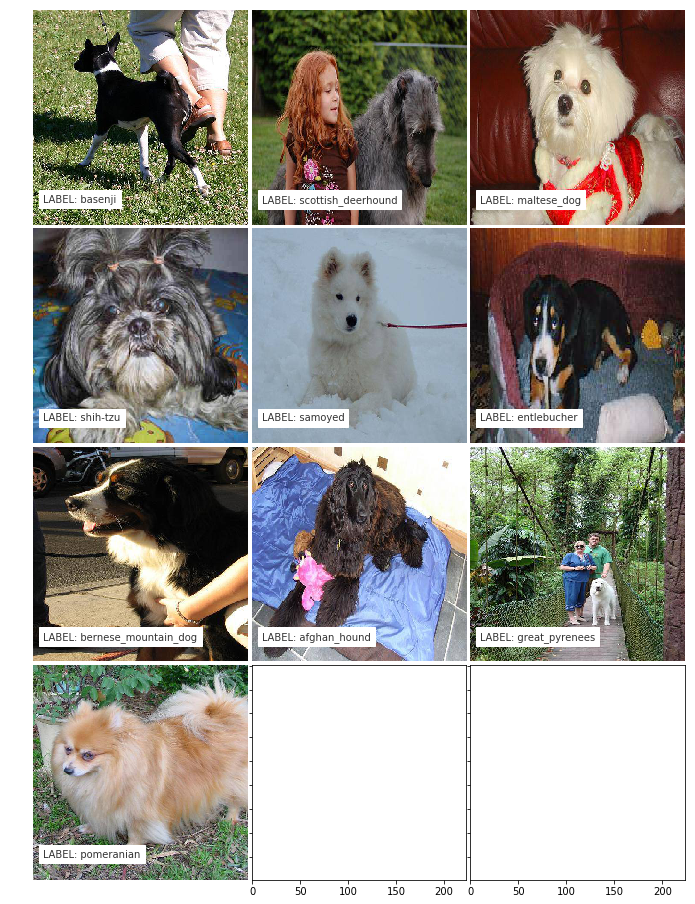

In [4]:
from support import split_train_val

# Make sure to have the same split
SEED = 2018

(train_idx, valid_idx, ytr, yv, labels, selected_breed_list) = split_train_val(labels, NUM_CLASSES, seed=SEED)

from keras.preprocessing import image
from support import show_images

show_images(NUM_CLASSES, labels, data_dir)

## Data Preprocessing

Before feeding the data into the model, we have to preprocess the images.

- The `xception.preprocess_input` method will scale pixels between -1 and 1, sample-wise.
- The `ImageDataGenerator` class will apply the distortions (defined by the parameters) during the training. **Be careful**: [data augmentation could be a bottleneck in the input data pipeline](https://www.tensorflow.org/performance/datasets_performance) if the cpu is not faster enough to provide the preprocessed / augmented data for the computation to the gpu.

In [5]:
# DATA LOADER
from keras.applications import xception
from support import read_img

INPUT_SIZE = 299

x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, data_dir, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Total Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print('Train (images, H, W, C):', Xtr.shape,
      '\nVal (images, H, W, C):', Xv.shape, 
      '\nTrain Labels (images, labels)', ytr.shape,
      '\nVal Labels (images, labels)', yv.shape)

# Data Loader
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator()

1141it [00:10, 106.64it/s]


Total Images shape: (1141, 299, 299, 3) size: 306,019,623
Train (images, H, W, C): (887, 299, 299, 3) 
Val (images, H, W, C): (254, 299, 299, 3) 
Train Labels (images, labels) (887, 10) 
Val Labels (images, labels) (254, 10)


### Plotting Data Augmentation

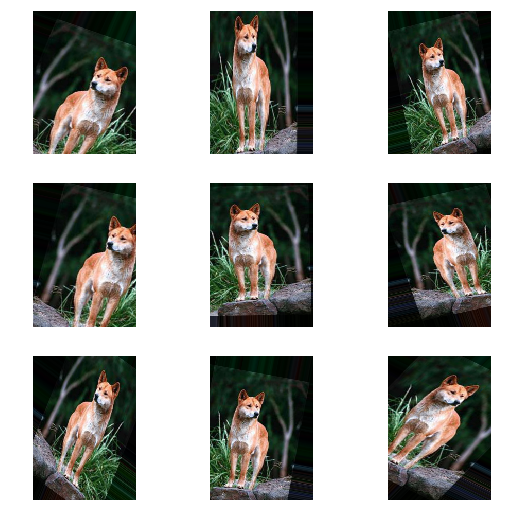

In [6]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

input_path = '/floyd/data/dogbreed/train/00a338a92e4e7bf543340dc849230e75.jpg' # An image from the dataset
# Number of samples to show
count = 9

# load image to array
image = img_to_array(load_img(input_path))

# reshape to array rank 4
image = image.reshape((1,) + image.shape)

# let's create infinite flow of images
images_flow = train_datagen.flow(image, batch_size=1)

plt.figure(figsize=(9,9))
for idx, new_images in enumerate(images_flow):
    if idx < count:
        plt.subplot(330 + 1 + idx)
        new_image = array_to_img(new_images[0], scale=True)
        plt.imshow(new_image)
        plt.axis('off')
    else:
        plt.show()
        break

## Model definition

We have built new layers on the top of the [Xception](https://arxiv.org/abs/1610.02357) model. 

<img src="https://raw.githubusercontent.com/floydhub/image-classification-template/v1/images/xception.png" width="600" height="600" align="center"/>

*Image from the [paper](https://arxiv.org/abs/1610.02357)*

In [7]:
### MODEL - BOTTLENECK FEATURES - OPTMIZER

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

## Train & Evaluate

If you left the default hyperpameters in the Notebook untouched, your training should take approximately:

- On CPU machine: 15-20 minutes for 1 epochs.
- On GPU machine: 1 minute for 3 epochs.

You should get an accuracy of > 96%. *Note*: The model will start overfitting after 2 to 3 epochs.

In [8]:
# TRAINING
hist = model.fit_generator(train_datagen.flow(Xtr, ytr, batch_size=BATCH_SIZE),
                           steps_per_epoch=train_idx.sum() // BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE),
                           validation_steps=valid_idx.sum() // BATCH_SIZE)

Epoch 1/1
221/221 [==============================] - 776s 4s/step - loss: 0.8327 - acc: 0.7557 - val_loss: 0.1110 - val_acc: 0.9802


In [9]:
# EVAL
test_gen = test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE, shuffle=False)
probabilities = model.predict_generator(test_gen)

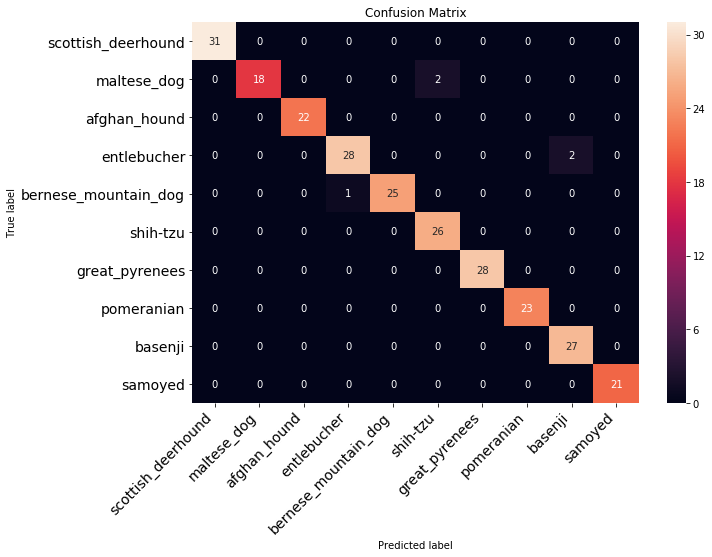

In [10]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
from support import print_confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1))
_ = print_confusion_matrix(cnf_matrix, selected_breed_list)

In [12]:
# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1), target_names=selected_breed_list)
print(report)

                      precision    recall  f1-score   support

  scottish_deerhound       1.00      1.00      1.00        31
         maltese_dog       1.00      0.90      0.95        20
        afghan_hound       1.00      1.00      1.00        22
         entlebucher       0.97      0.93      0.95        30
bernese_mountain_dog       1.00      0.96      0.98        26
            shih-tzu       0.93      1.00      0.96        26
      great_pyrenees       1.00      1.00      1.00        28
          pomeranian       1.00      1.00      1.00        23
             basenji       0.93      1.00      0.96        27
             samoyed       1.00      1.00      1.00        21

         avg / total       0.98      0.98      0.98       254



## It's your turn

Test out the model you just trained. Run the code Cell below and type your URL in the widget, Have fun!🎉

*Note*: the dog breeds available are the ones in the first Code Cell output.

Here are some URLs to test:

- Bernese: https://cdn.pixabay.com/photo/2016/02/06/19/18/dog-1183475_960_720.jpg
- Shih-tzu: https://cdn.pixabay.com/photo/2016/10/08/11/21/shih-tzu-puppy-1723492_960_720.jpg
- Samoyed: https://cdn.pixabay.com/photo/2017/06/14/00/59/samoyed-2400687_960_720.jpg

In [13]:
# Testing on url images
from support import prediction_from_url
from ipywidgets import interact_manual
from ipywidgets import widgets

def get_prediction(url):
    prediction_from_url(url, model, selected_breed_list)

interact_manual(get_prediction, url=widgets.Text(placeholder='Insert an URL'));

interactive(children=(Text(value='', description='url', placeholder='Insert an URL'), Button(description='Run …

## Save the result

In [14]:
# Saving Model Weight
model.save_weights('models/tl_xception_weights.h5')